# Random Forest multietiqueta con búsqueda Repeated K-Fold
Implementamos un **Random Forest** para clasificación multietiqueta de eventos sísmicos, con optimización de *todos* sus hiperparámetros mediante **Repeated K-Fold CV** (5 pliegues × 3 repeticiones). Se muestran:
1. Gráfica de optimización de λ (λ ≡ `ccp_alpha`).
2. Curva de aprendizaje (tamaño de entrenamiento vs F1-micro).

> **Nota** `ccp_alpha` actúa como parámetro de regularización en cada árbol: mayor λ ⇒ poda más agresiva ⇒ modelo más simple.

## Bloque 1 – Importaciones

In [68]:
# ── Bloque 1 ────────────────────────────────────────────────────────────────
import os, joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, hamming_loss, make_scorer

## Bloque 2 – Ruta de trabajo

In [69]:
# ── Bloque 2 ────────────────────────────────────────────────────────────────
# Ajusta ruta para que el notebook funcione desde cualquier subcarpeta
if os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
    while os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
        os.chdir('..')
    print('CWD cambiado →', os.getcwd())

## Bloque 3 – Carga de datos

In [70]:
# ── Bloque 3 ────────────────────────────────────────────────────────────────
df = pd.read_json('data/processed/dataset_final.json')
print('Shape:', df.shape)
df.head()

Shape: (1674, 92)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-,label
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-


## Bloque 4 – Separación X / y

In [71]:
# ── Bloque 4 ────────────────────────────────────────────────────────────────
label_cols = [
    '1 Stiker Slip (SS)','2 Normal-Oblique (SO)','3 Reverse-Oblique (RO)',
    '4-6','6-8','0-200','200-400','400-600','600-'
]
drop_cols = ['Archivo','Falla_lbl','Mag_lbl','Vs_lbl','Combo', 'label', *label_cols]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
y = df[label_cols].values

print(f'X: {X.shape} | y: {y.shape}')

X: (1674, 82) | y: (1674, 9)


## Bloque 5 – Hold-out Test (20 %)

In [72]:
# ── Bloque 5 ────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)
print(f'Train: {X_train.shape}   Test: {X_test.shape}')

Train: (1339, 82)   Test: (335, 82)


## Bloque 6 – Pipeline base

In [73]:
# ── Bloque 6 ────────────────────────────────────────────────────────────────
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1)))
])

## Bloque 7 – Grid y Repeated K-Fold

In [ ]:
# ── Bloque 7 ────────────────────────────────────────────────────────────────
# λ = ccp_alpha
lambda_vals = np.concatenate(([0.0], np.logspace(-4, -1, 4)))  # 0,1e-4,1e-3,1e-2,1e-1

param_grid = {
    'clf__estimator__n_estimators': [200, 400, 800],
    'clf__estimator__max_depth': [None, 50],
    'clf__estimator__min_samples_split': [ 7, 14],
    'clf__estimator__min_samples_leaf': [5,10],
    'clf__estimator__max_features': ['log2'],
    'clf__estimator__bootstrap': [True],
    'clf__estimator__ccp_alpha': lambda_vals
}

rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=42)
scorer = make_scorer(f1_score, average='micro')

grid = GridSearchCV(
    base_pipe,
   param_grid=param_grid,
    scoring=scorer,
    cv=rkf,
    n_jobs=-1,
    verbose= 2
)

grid.fit(X_train, y_train)
print('Mejores hiperparámetros:')
print(json.dumps(grid.best_params_, indent=2))
print(f"Mejor F1-micro CV: {grid.best_score_:.4f}")

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV] END clf__estimator__bootstrap=True, clf__estimator__ccp_alpha=0.0, clf__estimator__max_depth=None, clf__estimator__max_features=log2, clf__estimator__min_samples_leaf=5, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; total time=   4.1s
[CV] END clf__estimator__bootstrap=True, clf__estimator__ccp_alpha=0.0, clf__estimator__max_depth=None, clf__estimator__max_features=log2, clf__estimator__min_samples_leaf=5, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; total time=   4.3s
[CV] END clf__estimator__bootstrap=True, clf__estimator__ccp_alpha=0.0, clf__estimator__max_depth=None, clf__estimator__max_features=log2, clf__estimator__min_samples_leaf=5, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; total time=   4.6s
[CV] END clf__estimator__bootstrap=True, clf__estimator__ccp_alpha=0.0, clf__estimator__max_depth=None, clf__estimator__max_features=log2, clf

## Bloque 8 – Optimización de λ

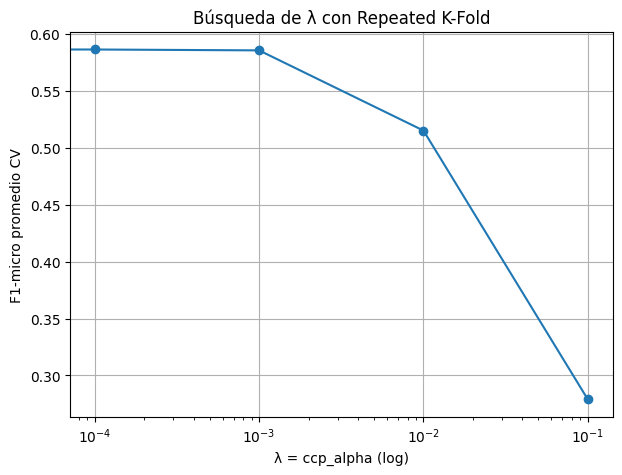

In [ ]:
# ── Bloque 8 ────────────────────────────────────────────────────────────────
results = pd.DataFrame(grid.cv_results_)
results['lambda'] = results['param_clf__estimator__ccp_alpha'].astype(float)

# Promedia F1 por valor de λ
lambda_mean = (results
               .groupby('lambda')['mean_test_score']
               .mean()
               .sort_index())

plt.figure(figsize=(7,5))
plt.plot(lambda_mean.index, lambda_mean.values, marker='o')
plt.xscale('log')
plt.xlabel('λ = ccp_alpha (log)')
plt.ylabel('F1-micro promedio CV')
plt.title('Búsqueda de λ con Repeated K-Fold')
plt.grid(True)
plt.show()

## Bloque 9 – Curva de aprendizaje

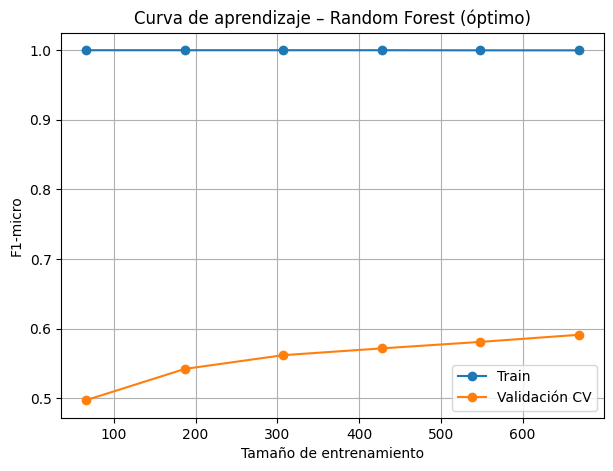

In [ ]:
# ── Bloque 9 ────────────────────────────────────────────────────────────────
best_params = grid.best_params_
best_lambda = best_params['clf__estimator__ccp_alpha']

# Reconstruye pipeline con los hiperparámetros óptimos encontrados
best_rf = RandomForestClassifier(
    n_estimators       = best_params['clf__estimator__n_estimators'],
    max_depth          = best_params['clf__estimator__max_depth'],
    min_samples_split  = best_params['clf__estimator__min_samples_split'],
    min_samples_leaf   = best_params['clf__estimator__min_samples_leaf'],
    max_features       = best_params['clf__estimator__max_features'],
    bootstrap          = best_params['clf__estimator__bootstrap'],
    ccp_alpha          = best_lambda,
    random_state       = 42,
    n_jobs             = -1
)

best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MultiOutputClassifier(best_rf))
])

train_sizes, tr_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train,
    cv=rkf, scoring=scorer,
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='Validación CV')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1-micro')
plt.title('Curva de aprendizaje – Random Forest (óptimo)')
plt.legend()
plt.grid(True)
plt.show()

## Bloque 10 – Evaluación en Test

In [ ]:
# ── Bloque 10 ────────────────────────────────────────────────────────────────
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

print(f"Test F1-micro : {f1_score(y_test, y_pred, average='micro') :.4f}")
print(f"Test F1-macro : {f1_score(y_test, y_pred, average='macro') :.4f}")
print(f"Hamming loss : {hamming_loss(y_test, y_pred) :.4f}")

Test F1-micro : 0.6221
Test F1-macro : 0.5230
Hamming loss : 0.2100


## Bloque 11 – Guardar modelo

In [ ]:
# ── Bloque 11 ────────────────────────────────────────────────────────────────
os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, 'models/rf_repkfold.pkl')
print('Modelo guardado en models/rf_repkfold.pkl')

Modelo guardado en models/rf_repkfold.pkl
